In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

(vectorization)=
# Vectorization

Before you start with this notebook, please make sure you have read about the [Jax basics](https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html).
The main idea is that Jax replaces Numpy arrays and functions with Jax arrays and functions. This allows Jax to automatically calculate gradients and other derivatives and to compile functions for faster execution.
The main difference between Numpy and Jax is that Jax arrays are immutable. This means that you cannot change the values of a Jax array. Instead, you have to create a new array with the desired values. For example, the `+=` operator is not supported for Jax arrays. This is essential so that we only write pure functions and Jax can calculate the derivatives.

Vectorization takes a function that works on single values and turns it into a function that works on arrays. This is useful because it allows us to write code that is more concise and often faster.
Let's start by making a simple generalized linear model in Jax.
We will use radial basis functions:

$$
f(x) = \sum_{i=1}^n w_i \phi_i(x)
$$

where $\phi_i(x) = \exp(-\frac{1}{2\sigma^2}||x - c_i||^2)$ is a radial basis function with center $c_i$ and $\sigma$ is the bandwidth parameter.

First, start by making the radial basis function:

In [2]:
import jax.numpy as jnp

rbf = lambda x, c, sigma2 : jnp.exp(-jnp.sum((x-c)**2, axis=-1) / sigma2)

Let's demonstrate it in 1D:

In [5]:
x = jnp.array([0.5])
c = jnp.array([0.0])
sigma2 = 0.1

rbf(x, c, sigma2)

Array(0.082085, dtype=float32)

Now we would like to vectorize it with respect to the input $c_i$ so that we can pass all the centers at once.
We can do this by using the [`vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) function:

In [7]:
from jax import vmap

phi = vmap(rbf, in_axes=(None, 0, None), out_axes=0)

What just happened here? First, let's use it:

In [8]:
centers = jnp.linspace(-1, 1, 10)
phi(x, centers, sigma2)

Array([1.6918980e-10, 8.1134310e-08, 1.4491094e-05, 9.6397504e-04,
       2.3883473e-02, 2.2039244e-01, 7.5746524e-01, 9.6960723e-01,
       4.6227053e-01, 8.2084998e-02], dtype=float32)

Let's break down how we called `vmap`:
- The first argument is just the function we want to vectorize.
- The second argument, `in_axes`, is a description of how we want to vectorize the function. The function has three inputs. So we pass a tuple with three elements. The first element is `None` because we don't want to vectorize with respect to the first input, `x`. Same with the third element. The second element is `0` because we want to vectorize with respect to the second input, `c`. The `0` here means that we want to vectorize with respect to the first dimension of `c`. Wait a second. Does that mean that our code works with 2D arrays? Yes indeed!
- The third argument of `vmap` is `out_axes`. This is a description of how we want to vectorize the output of the function. The output of the function is a scalar. So we pass `0` to indicate that we want to vectorize with respect to the first dimension of the output.

Okay. Let's try it on 2D arrays:

In [14]:
# We will try it on this x:
x_2d = jnp.array([0.5, 0.7])

# Here are the 2D centers:
c1 = jnp.linspace(-1, 1, 10)
c2 = jnp.linspace(-1, 1, 10)
C = jnp.meshgrid(c1, c2)
centers = jnp.stack(C, axis=-1).reshape(-1, 2)
centers 

Array([[-1.        , -1.        ],
       [-0.7777778 , -1.        ],
       [-0.5555556 , -1.        ],
       [-0.33333334, -1.        ],
       [-0.11111113, -1.        ],
       [ 0.11111113, -1.        ],
       [ 0.33333337, -1.        ],
       [ 0.5555556 , -1.        ],
       [ 0.7777778 , -1.        ],
       [ 1.        , -1.        ],
       [-1.        , -0.7777778 ],
       [-0.7777778 , -0.7777778 ],
       [-0.5555556 , -0.7777778 ],
       [-0.33333334, -0.7777778 ],
       [-0.11111113, -0.7777778 ],
       [ 0.11111113, -0.7777778 ],
       [ 0.33333337, -0.7777778 ],
       [ 0.5555556 , -0.7777778 ],
       [ 0.7777778 , -0.7777778 ],
       [ 1.        , -0.7777778 ],
       [-1.        , -0.5555556 ],
       [-0.7777778 , -0.5555556 ],
       [-0.5555556 , -0.5555556 ],
       [-0.33333334, -0.5555556 ],
       [-0.11111113, -0.5555556 ],
       [ 0.11111113, -0.5555556 ],
       [ 0.33333337, -0.5555556 ],
       [ 0.5555556 , -0.5555556 ],
       [ 0.7777778 ,

Here we go:

In [15]:
phi(x_2d, centers, sigma2)

Array([4.7562314e-23, 2.2808324e-20, 4.0737123e-18, 2.7099149e-16,
       6.7140702e-15, 6.1956259e-14, 2.1293739e-13, 2.7257452e-13,
       1.2995268e-13, 2.3075580e-14, 5.5479779e-20, 2.6605014e-17,
       4.7518256e-15, 3.1610093e-13, 7.8317292e-12, 7.2269815e-11,
       2.4838404e-10, 3.1794808e-10, 1.5158498e-10, 2.6916859e-11,
       2.4102930e-17, 1.1558467e-14, 2.0644120e-12, 1.3732855e-10,
       3.4024576e-09, 3.1397281e-08, 1.0790907e-07, 1.3813091e-07,
       6.5855374e-08, 1.1693903e-08, 3.9000916e-15, 1.8702704e-12,
       3.3404224e-10, 2.2221114e-08, 5.5055119e-07, 5.0803897e-06,
       1.7460752e-05, 2.2350945e-05, 1.0656060e-05, 1.8921869e-06,
       2.3504205e-13, 1.1271351e-10, 2.0131354e-08, 1.3391754e-06,
       3.3179396e-05, 3.0617364e-04, 1.0522862e-03, 1.3469983e-03,
       6.4219604e-04, 1.1403423e-04, 5.2757451e-12, 2.5299631e-09,
       4.5186761e-07, 3.0059076e-05, 7.4474415e-04, 6.8723680e-03,
       2.3619594e-02, 3.0234693e-02, 1.4414707e-02, 2.5596090e

Now, let's also vectorize this with respect to the first input, `x`:

In [17]:
vphi = vmap(phi, in_axes=(0, None, None), out_axes=0)

In [28]:
xs = jnp.linspace(-1, 1, 100).reshape(-1, 1)
cs = jnp.linspace(-1, 1, 5).reshape(-1, 1)
phis = vphi(xs, cs, sigma2)
print(phis.shape)

(100, 5)


Let's plot them:

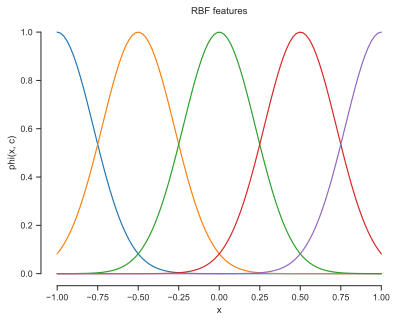

In [30]:
fig, ax = plt.subplots()
ax.plot(xs, phis)
ax.set(xlabel="x", ylabel="phi(x, c)", title="RBF features")
sns.despine(trim=True);

And the same code also works on 2D. Here are some grid points:

In [33]:
x1 = jnp.linspace(-1, 1, 50)
x2 = jnp.linspace(-1, 1, 50)
X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.stack((X1, X2), axis=-1).reshape(-1, 2)
X.shape

(2500, 2)

We will evaluate on the centers we constructed previously:

In [34]:
centers.shape

(100, 2)

Here are all the basis functions on these points:

In [36]:
phis = vphi(X, centers, sigma2)
phis.shape

(2500, 100)

Let's do the contour of one of them:

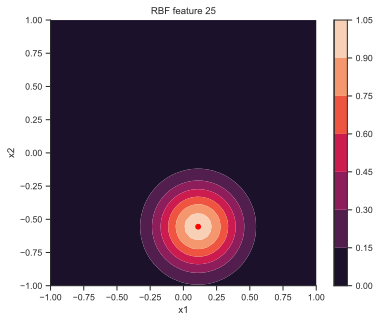

In [46]:
i = 25
fig, ax = plt.subplots()
ax.set_aspect("equal")
c = ax.contourf(X1, X2, phis[:, i].reshape(50, 50))
ax.plot(centers[i, 0], centers[i, 1], "ro")
ax.set(xlabel="x1", ylabel="x2", title=f"RBF feature {i}")
plt.colorbar(c)
sns.despine(trim=True);

It is remarkable that we can write code that works on both 1D and 2D arrays without changing anything. And we didn't even write a loop. What is more is that `Jax` can also compile our code! This is the power of vectorization.

We could have also done it in using decorators. As a teaser for the next section, let's also compile it using `jax.jit`:

In [49]:
from jax import jit
import functools as ft

@jit
@ft.partial(vmap, in_axes=(0, None, None), out_axes=0)
@ft.partial(vmap, in_axes=(None, 0, None), out_axes=0)
def rbf_basis(x, c, sigma2):
    return jnp.exp(-jnp.sum((x-c)**2, axis=-1) / sigma2)

In [52]:
rbf_basis(X, centers, sigma2).shape

(2500, 100)

Compare the time it takes to run the function with and without `jit`.
Here is without `jit`:

In [55]:
%timeit vphi(X, centers, sigma2).block_until_ready()

2.56 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Here is with `jit`:

In [56]:
%timeit rbf_basis(X, centers, sigma2).block_until_ready()

255 µs ± 4.46 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


I hope you are sold on why we go through the trouble of explaining functional programming.